In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import os
import time
import math
import h5py
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

import tensorflow as tf
tf.enable_eager_execution()

from sklearn.manifold import TSNE

from batch import batchsampler
from tripletloss import *

In [2]:
class EmbedNet(tf.keras.Model):
    def __init__(self, rnndim, fcdim1, fcdim2):
        super(EmbedNet, self).__init__()

        self.gru = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(rnndim, return_sequences=True) )
        self.dense1 = tf.keras.layers.Dense(fcdim1)
        self.dense2 = tf.keras.layers.Dense(fcdim2)

    def call(self, inputs, training=False):
        state = tf.keras.layers.Masking(mask_value=99.)(inputs)
        state = self.gru(state)
        state = tf.keras.layers.GlobalAveragePooling1D()(state)
        state = self.dense1(state)
        state = tf.keras.layers.PReLU()(state)
        state = tf.keras.layers.Dropout(0.2)(state, training=training)
        
        state = self.dense2(state)

        return tf.math.l2_normalize(state)

In [3]:
tripnet = EmbedNet(16, 16, 16)
tripnet.build((None, 300, 36))
tripnet.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  5088      
_________________________________________________________________
dense (Dense)                multiple                  528       
_________________________________________________________________
dense_1 (Dense)              multiple                  272       
Total params: 5,888
Trainable params: 5,888
Non-trainable params: 0
_________________________________________________________________


In [4]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3);
lossmetric = tf.keras.metrics.Mean();

In [5]:
batchgen = batchsampler('data/ami_train.hdf5', batchdim = [6, 25], nsec = 3.0)

for steps in range(500):
    epoch = batchgen.nepoch
    batch = batchgen.getbatch()
    xtrain, ytrain = batch[0], batch[1]
        
    with tf.GradientTape() as tape:
        embedding = tripnet(xtrain)
        loss = batch_all(embedding, ytrain)

    grads = tape.gradient(loss, tripnet.trainable_variables)
    optimizer.apply_gradients(zip(grads, tripnet.trainable_variables))
    lossmetric(loss)
        
    if batchgen.nepoch is not epoch and epoch % 20 == 0:
        print('epoch %s: mean loss = %s' % (epoch, lossmetric.result().numpy() ))
pass;

epoch 0: mean loss = 0.19862822
epoch 20: mean loss = 0.19511813
epoch 40: mean loss = 0.19022606
epoch 60: mean loss = 0.18230897
epoch 80: mean loss = 0.17880009
epoch 100: mean loss = 0.17554231
epoch 120: mean loss = 0.17413826
epoch 140: mean loss = 0.17303023
epoch 160: mean loss = 0.17210537
epoch 180: mean loss = 0.17102593
epoch 200: mean loss = 0.17039151
epoch 220: mean loss = 0.16993625
epoch 240: mean loss = 0.16935939
epoch 260: mean loss = 0.1691245
epoch 280: mean loss = 0.16872008
epoch 300: mean loss = 0.1681616
epoch 320: mean loss = 0.16781534
epoch 340: mean loss = 0.16735564
epoch 360: mean loss = 0.166911
epoch 380: mean loss = 0.16623394
epoch 400: mean loss = 0.1659962
epoch 420: mean loss = 0.1655249
epoch 440: mean loss = 0.16495445
epoch 460: mean loss = 0.16492793
epoch 480: mean loss = 0.16451173


In [6]:
listembedding = list()
listlabel = list()

In [7]:
for i in range(3):
    testbatch, testlabel = batchgen.getbatch()
    testembedding = tripnet(testbatch)
    listembedding.append(testembedding.numpy())
    listlabel.append(testlabel.numpy())

In [8]:
X = np.concatenate(listembedding, axis=0)
y_true = np.concatenate(listlabel, axis=0)

In [9]:
X = np.vstack(X)
_, y_true = np.unique(y_true, return_inverse=True)

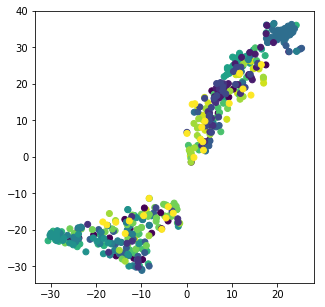

In [10]:
# apply tSNE on embeddings
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, metric="cosine")
X_2d = tsne.fit_transform(X)

# plot 
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)
plt.scatter(*X_2d.T, c=y_true)